## To run this notebook, press the "Runtime" button in the menu tab and then press the "Run all" button.

# Recognize Organic Waste and Recycle Waste using Transfer Learning

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

tf.__version__

'2.2.0'

In [2]:
TRAINING_DIR = "Dataset-organic-recycle/TRAIN"
VALIDATION_DIR = "Dataset-organic-recycle/TEST"

## Setup Input Pipeline

Use `ImageDataGenerator` to rescale the images. rotation_range,horizontal_flip, shear_range and fill mode to minimum augmentation in train image

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [3]:
#ImageData Generator
batch_size = 128
image_size=224
training_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      horizontal_flip=True,
      shear_range = 0.2,
      fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(image_size,image_size),
    #class_mode='binary',
  batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(image_size,image_size),
	#class_mode='binary',
  batch_size=batch_size
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [4]:
#Get Size train_generator and validation_generator
train_num = train_generator.samples
valid_num = validation_generator.samples

print(train_num)
print(valid_num)

22564
2513


In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((128, 224, 224, 3), (128, 2))

Save the labels in a file which will be downloaded later with TFLITE file

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels_riset3.txt', 'w') as f:
  f.write(labels)

{'O': 0, 'R': 1}


In [7]:
!cat labels_riset1.txt

O
R

## Create the base model from the pre-trained convnets

Create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [8]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [9]:
base_model.trainable = False

### Add a classification head

In [10]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

### Compile the model

You must compile the model before training it.  Since there are multiple classes, use a categorical cross-entropy loss.

In [11]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 2,626,722
Trainable params: 368,738
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [14]:
# import other libs as needed for building model
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 15

filepath = 'save/best_model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

history = model.fit(train_generator, 
                    epochs=epochs, 
                    steps_per_epoch=train_num//batch_size, 
                    validation_data = validation_generator,
                    validation_steps=valid_num//batch_size,
                    callbacks=[checkpoint])

Epoch 1/15
176/176 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8920
Epoch 00001: val_loss improved from inf to 0.27553, saving model to save/best_model.h5
176/176 [==============================] - 864s 5s/step - loss: 0.2821 - accuracy: 0.8920 - val_loss: 0.2755 - val_accuracy: 0.8771
Epoch 2/15
176/176 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9345
Epoch 00002: val_loss improved from 0.27553 to 0.24747, saving model to save/best_model.h5
176/176 [==============================] - 803s 5s/step - loss: 0.1709 - accuracy: 0.9345 - val_loss: 0.2475 - val_accuracy: 0.8976
Epoch 3/15
176/176 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9445
Epoch 00003: val_loss did not improve from 0.24747
176/176 [==============================] - 887s 5s/step - loss: 0.1471 - accuracy: 0.9445 - val_loss: 0.3049 - val_accuracy: 0.8672
Epoch 4/15
176/176 [==============================] - ETA: 0s - loss: 0.1279 - accuracy

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

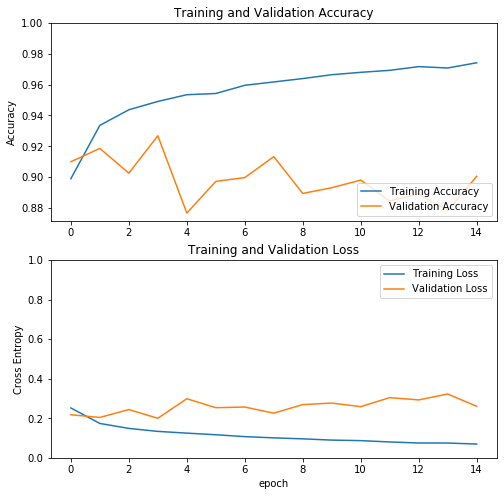

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [17]:
base_model.trainable = True

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 2,626,722
Trainable params: 2,231,330
Non-trainable params: 395,392
_________________________________________________________________


In [21]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


### Continue Train the model

In [23]:
filepath = 'save/best_model_tunning.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

history_fine = model.fit(train_generator, 
                    epochs=5, 
                    steps_per_epoch=train_num//batch_size, 
                    validation_data = validation_generator,
                    validation_steps=valid_num//batch_size,
                         callbacks=[checkpoint])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9540
Epoch 00001: val_loss improved from inf to 0.38179, saving model to save/best_model_tunning.h5
176/176 [==============================] - 723s 4s/step - loss: 0.1322 - accuracy: 0.9540 - val_loss: 0.3818 - val_accuracy: 0.8956
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9735
Epoch 00002: val_loss did not improve from 0.38179
176/176 [==============================] - 765s 4s/step - loss: 0.0723 - accuracy: 0.9735 - val_loss: 0.5770 - val_accuracy: 0.8873
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9819
Epoch 00003: val_loss did not improve from 0.38179
176/176 [==============================] - 852s 5s/step - loss: 0.0473 - accuracy: 0.9819 - val_loss: 0.7286 - val_accuracy: 0.8705
Epoch 4/5
176/176 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9873
Epoch 00004: val_loss did n

## Conclusion

After we see the results of the training and fine tuning, we can see the validation of the accuracy of the training is better than after going through the fine tuning stage which trains the weight. So we will use the model of the best validation results obtained from the callback

## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [20]:
from tensorflow import keras
saved_model_file = 'save/best_model.h5'

best_model = keras.models.load_model(saved_model_file)
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

with open('model_riset3_softmax.tflite', 'wb') as f:
  f.write(tflite_model)

Download the converted model and labels

In [ ]:
#from google.colab import files

#files.download('model_riset1.tflite')
#files.download('labels_riset1.txt')

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


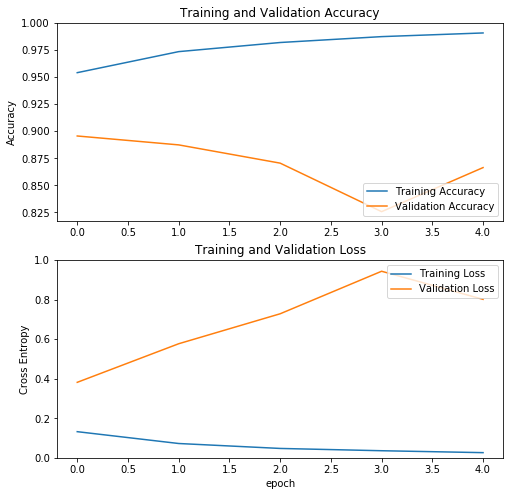

In [25]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
from tensorflow.keras.preprocessing import image

path = "/Users/mac-eko/RisetDeepLearning/Riset Sampah Recycle-Organik/Dataset-organic-recycle/TEST/R/R_10421.jpg"
img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=5)
  
  #print(fn)
print(classes)
max_index_col = np.argmax(classes, axis=1)

[[0.19465236 0.8053476 ]]


In [26]:
# Preparing test data
PATH_TEST=Path("/Users/mac-eko/RisetDeepLearning/Riset Sampah Recycle-Organik/Dataset-organic-recycle/TEST")
organic_dir = PATH_TEST / 'O'
recycle_dir = PATH_TEST / 'R'

organic_waste = organic_dir.glob('*.jpg')
recycle_waste = recycle_dir.glob('*.jpg')

test_data = []
test_labels = []

for img in organic_waste:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
#for img in recycle_waste:
#    img = cv2.imread(str(img))
#    img = cv2.resize(img, (224,224))
#    if img.shape[2] ==1:
#        img = np.dstack([img, img, img])
#    else:
#        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    img = img.astype(np.float32)/255.
#    label = to_categorical(1, num_classes=2)
#    test_data.append(img)
#    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (1401, 224, 224, 3)
Total number of labels: (1401, 2)


In [33]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(1401,)
(1401,)


<Figure size 432x288 with 0 Axes>

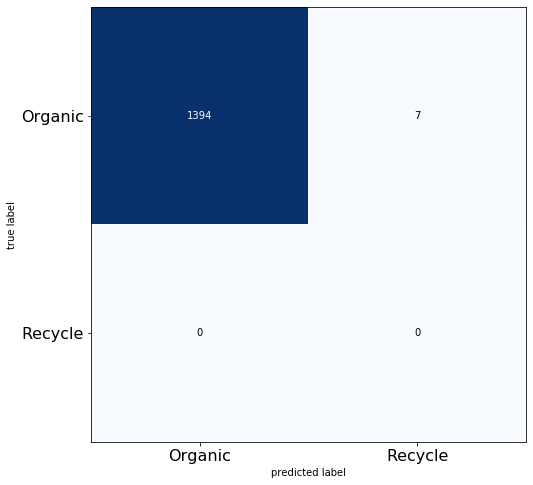

In [34]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Organic', 'Recycle'], fontsize=16)
plt.yticks(range(2), ['Organic', 'Recycle'], fontsize=16)
plt.show()